In [1]:
import tarfile

import numpy as np

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
# Default QA1 with 1000 samples
#challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
#challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

In [3]:
import spacy

nlp = spacy.load('en')

In [4]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.text.strip() for x in nlp(sent) if x.text.strip()], [x.pos_ for x in nlp(sent) if x.text.strip()]

In [5]:
def parse_stories(lines):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true,
    only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        # Get answer line
        if '\t' in line:
            q, a, _ = line.split('\t')
            q = tokenize(q)
            data.append(([x for x in story if x], q, a))
            story.append(('', '')) # End token
        # Get story line
        else:
            story.append(tokenize(line))
    return data

In [6]:
def get_stories(f):
    '''Given a file name, read the file, retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines())
    def dual_flatten(data):
        words, pos = [], []
        for d in data:
            words.extend(d[0])
            pos.extend(d[1])
        return words, pos
    data = [(dual_flatten(story), q, answer) for story, q, answer in data]
    return data

In [7]:
def vectorize_stories(data, word_idx, pos_idx, story_maxlen, query_maxlen):
    xs = []
    xspos = []
    xqs = []
    xqspos = []
    ys = []
    for story, query, answer in data:
        story, storypos = story
        query, querypos = query
        x = [word_idx[w] for w in story]
        xpos = [pos_idx[w] for w in storypos]
        xq = [word_idx[w] for w in query]
        xqpos = [pos_idx[w] for w in querypos]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xspos.append(xpos)
        xqs.append(xq)
        xqspos.append(xqpos)
        ys.append(y)
    return (
        pad_sequences(xs, maxlen=story_maxlen), pad_sequences(xspos, maxlen=story_maxlen),
        pad_sequences(xqs, maxlen=query_maxlen), pad_sequences(xqspos, maxlen=query_maxlen),
        np.array(ys)
    )

In [8]:
train = get_stories(tar.extractfile(challenge.format('train')))
test = get_stories(tar.extractfile(challenge.format('test')))

In [9]:
train[0]

((['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'John',
   'went',
   'to',
   'the',
   'hallway',
   '.'],
  ['PROPN',
   'VERB',
   'ADP',
   'DET',
   'NOUN',
   'PUNCT',
   'PROPN',
   'VERB',
   'ADP',
   'DET',
   'NOUN',
   'PUNCT']),
 (['Where', 'is', 'Mary', '?'], ['ADV', 'VERB', 'PROPN', 'PUNCT']),
 'bathroom')

In [10]:
def build_vocab(inputs, idx, use_answer):
    vocab = set()
    for story, q, answer in inputs:
        vocab |= set(story[idx] + q[idx])
        if use_answer:
            vocab.add(answer)
    return sorted(vocab)

word_vocab = build_vocab(train + test, 0, True)
pos_vocab = build_vocab(train + test, 1, False)

In [11]:
# Reserve 0 for masking via pad_sequences
word_vocab_size = len(word_vocab) + 1
pos_vocab_size = len(pos_vocab) + 1

word_idx = dict((c, i + 1) for i, c in enumerate(word_vocab))
pos_idx = dict((c, i + 1) for i, c in enumerate(pos_vocab))

story_maxlen = max(map(len, (x[0] for x, _, _ in train + test)))
query_maxlen = max(map(len, (x[0] for _, x, _ in train + test)))

In [12]:
x, xpos, xq, xqpos, y = vectorize_stories(train, word_idx, pos_idx, story_maxlen, query_maxlen)
tx, txpos, txq, txqpos, ty = vectorize_stories(test, word_idx, pos_idx, story_maxlen, query_maxlen)

In [13]:
print('word_vocab = {}'.format(word_vocab))
print('pos_vocab = {}'.format(pos_vocab))
print('x.shape = {}'.format(x.shape))
print('xpos.shape = {}'.format(xpos.shape))
print('xq.shape = {}'.format(xq.shape))
print('xqpos.shape = {}'.format(xqpos.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

word_vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went']
pos_vocab = ['ADP', 'ADV', 'DET', 'NOUN', 'PROPN', 'PUNCT', 'VERB']
x.shape = (10000, 68)
xpos.shape = (10000, 68)
xq.shape = (10000, 4)
xqpos.shape = (10000, 4)
y.shape = (10000, 22)
story_maxlen, query_maxlen = 68, 4


In [14]:
RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
POS_EMBED_HIDDEN_SIZE = 10
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 35
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))

RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100


In [17]:
print('Build model...')

def one_hot_embedder(n, input_tensor):
    U = np.eye(n)
    U[0, 0] = 0
    return layers.Embedding(n, n, weights=[U], trainable=False)(input_tensor)
    

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
sentence_pos = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(word_vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence_pos = one_hot_embedder(pos_vocab_size, sentence_pos)
encoded_sentence = layers.Dropout(0.3)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
question_pos = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(word_vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question_pos = one_hot_embedder(pos_vocab_size, question_pos)
encoded_question = layers.Dropout(0.3)(encoded_question)
merged_question = layers.concatenate([encoded_question, encoded_question_pos])
encoded_question = RNN(QUERY_HIDDEN_SIZE)(merged_question)

encoded_question = layers.RepeatVector(story_maxlen)(encoded_question)

merged = layers.concatenate([encoded_question, encoded_sentence, encoded_sentence_pos])
merged = RNN(SENT_HIDDEN_SIZE)(merged)
merged = layers.Dropout(0.3)(merged)
preds = layers.Dense(word_vocab_size, activation='softmax')(merged)

model = Model([sentence, sentence_pos, question, question_pos], preds)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Build model...


In [ ]:
print('Training')
model.fit([x, xpos, xq, xqpos], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)
loss, acc = model.evaluate([tx, txpos, txq, txqpos], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

In [18]:
accs = []
for n_ex in [10, 100, 1000, 3000, 10000]:
    print("Training", n_ex)
    model = Model([sentence, sentence_pos, question, question_pos], preds)
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit([x[:n_ex], xpos[:n_ex], xq[:n_ex], xqpos[:n_ex]], y[:n_ex],
          batch_size=BATCH_SIZE,
          epochs=15,
          validation_split=0.05)
    _, acc = model.evaluate([tx, txpos, txq, txqpos], ty,
                               batch_size=BATCH_SIZE)
    accs.append(acc)

Training 10
Train on 9 samples, validate on 1 samples
Epoch 1/15
9/9 [==============================] - 0s - loss: 3.0728 - acc: 0.0000e+00 - val_loss: 2.9533 - val_acc: 0.0000e+00
Epoch 2/15
9/9 [==============================] - 0s - loss: 2.8824 - acc: 0.5556 - val_loss: 2.7891 - val_acc: 0.0000e+00
Epoch 3/15
9/9 [==============================] - 0s - loss: 2.6290 - acc: 0.5556 - val_loss: 2.4550 - val_acc: 0.0000e+00
Epoch 4/15
9/9 [==============================] - 0s - loss: 1.9138 - acc: 0.5556 - val_loss: 2.5537 - val_acc: 0.0000e+00
Epoch 5/15
9/9 [==============================] - 0s - loss: 1.2987 - acc: 0.5556 - val_loss: 2.0064 - val_acc: 0.0000e+00
Epoch 6/15
9/9 [==============================] - 0s - loss: 1.1872 - acc: 0.5556 - val_loss: 1.6188 - val_acc: 0.0000e+00
Epoch 7/15
9/9 [==============================] - 0s - loss: 1.1686 - acc: 0.5556 - val_loss: 1.6902 - val_acc: 0.0000e+00
Epoch 8/15
9/9 [==============================] - 0s - loss: 1.2313 - acc: 0.5556

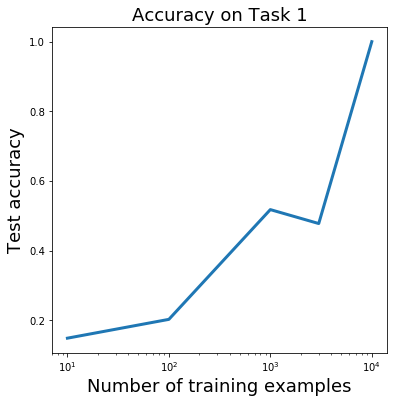

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=[6, 6])
plt.semilogx([10, 100, 1000, 3000, 10000], accs, linewidth=3)
plt.xlabel('Number of training examples', size=18)
plt.ylabel('Test accuracy', size=18)
plt.title('Accuracy on Task 1', size=18)
plt.show()